In [1]:
from simpletransformers.ner import NERModel, NERArgs

In [2]:
special_labels = {',': 'I-COMMA',
                  '.': 'I-DOT',
                  '?': 'I-QMARK',
                  '!': 'I-EMARK',
                  ':': 'I-COLON',
                  ';': 'I-SEMICOLON'}
normal_label = 'O'
labels_set = list(special_labels.values()) + [normal_label]

In [4]:
model_args = NERArgs()
model_args.overwrite_output_dir = True
model_args.save_steps = -1
model = NERModel('bert',
                 './bert_models/0/checkpoint-10708-epoch-1/',
                 labels = labels_set,
                 args=model_args,
                 use_cuda=True)
model.args.max_seq_length = 512

In [5]:
import pandas as pd

testdf = pd.read_csv('./preprocessed_wikitext/test.csv').dropna()

In [6]:
result, model_outputs, predictions = model.eval_model(testdf)

  0%|          | 0/5 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/269 [00:00<?, ?it/s]

In [7]:
groups = [df for _, df in testdf.groupby('sentence_id')]

In [8]:
print(len(predictions) == len(groups))

True


In [9]:
trues = []
for i, sentence in enumerate(predictions):
  trues.append(groups[i]['labels'].to_list()[:len(sentence)])

In [10]:
print(len(trues), len(predictions))

2147 2147


In [11]:
import itertools
ps = list(itertools.chain.from_iterable(predictions))
ts = list(itertools.chain.from_iterable(trues))

In [12]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_true=ts,y_pred=ps, labels=labels_set)
cm

array([[  8575,     85,      0,      0,      9,     60,   2362],
       [    55,   8414,      2,      0,      9,      1,    410],
       [     0,      1,     10,      0,      0,      0,      1],
       [     0,      4,      0,      1,      0,      0,     15],
       [    35,     35,      0,      0,    164,     20,     56],
       [   137,     44,      0,      0,     11,    303,     52],
       [  2262,    359,      1,      1,     30,     23, 192145]])

In [13]:
import numpy as np
summ = np.sum(cm, axis=1)
summ = np.expand_dims(summ, axis=1)

In [14]:
nor_cm = (cm/summ)
nor_cm

array([[7.73149400e-01, 7.66387161e-03, 0.00000000e+00, 0.00000000e+00,
        8.11468758e-04, 5.40979172e-03, 2.12965467e-01],
       [6.18603082e-03, 9.46350242e-01, 2.24946575e-04, 0.00000000e+00,
        1.01225959e-03, 1.12473288e-04, 4.61140479e-02],
       [0.00000000e+00, 8.33333333e-02, 8.33333333e-01, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 8.33333333e-02],
       [0.00000000e+00, 2.00000000e-01, 0.00000000e+00, 5.00000000e-02,
        0.00000000e+00, 0.00000000e+00, 7.50000000e-01],
       [1.12903226e-01, 1.12903226e-01, 0.00000000e+00, 0.00000000e+00,
        5.29032258e-01, 6.45161290e-02, 1.80645161e-01],
       [2.50457038e-01, 8.04387569e-02, 0.00000000e+00, 0.00000000e+00,
        2.01096892e-02, 5.53930530e-01, 9.50639854e-02],
       [1.16106580e-02, 1.84271716e-03, 5.13291688e-06, 5.13291688e-06,
        1.53987506e-04, 1.18057088e-04, 9.86264314e-01]])

In [15]:
nor_cm.sum(axis=1)

array([1., 1., 1., 1., 1., 1., 1.])

In [16]:
from sklearn import metrics 
print(metrics.classification_report(ts, ps))

              precision    recall  f1-score   support

     I-COLON       0.74      0.53      0.62       310
     I-COMMA       0.78      0.77      0.77     11091
       I-DOT       0.94      0.95      0.94      8891
     I-EMARK       0.50      0.05      0.09        20
     I-QMARK       0.77      0.83      0.80        12
 I-SEMICOLON       0.74      0.55      0.64       547
           O       0.99      0.99      0.99    194821

    accuracy                           0.97    215692
   macro avg       0.78      0.67      0.69    215692
weighted avg       0.97      0.97      0.97    215692



Text(114.0, 0.5, 'True Label')

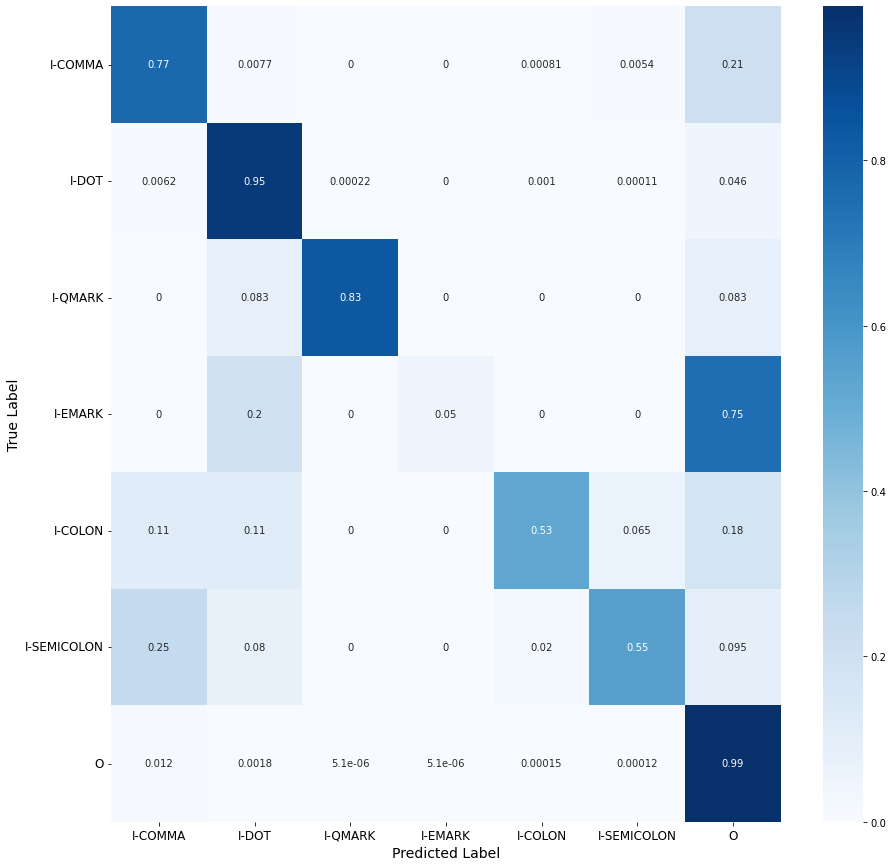

In [17]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
plot_labels = labels_set
fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(nor_cm,
            ax=ax, 
            annot=True,
            cmap='Blues',
            xticklabels=plot_labels,
            yticklabels=plot_labels)
plt.yticks(rotation=0,size=12)
plt.xticks(size=12)
ax.set_xlabel('Predicted Label',size=14)
ax.set_ylabel('True Label',size=14)